In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
from prob_cal_helper_functions import *

In [2]:
import warnings
warnings.filterwarnings("ignore", message="The `cv='prefit'` option is deprecated")

In [3]:
# Load in all the data
train_df = pd.read_parquet("../train_final_v3.parquet")
val_df = pd.read_parquet("../validationA_v3.parquet")
cal_df = pd.read_parquet("../validationB_v3.parquet")
test_df = pd.read_parquet("../test_v3.parquet")

In [4]:
# check shapes of the dataframes
print(train_df.shape)
print(val_df.shape)
print(cal_df.shape)
print(test_df.shape)

(112768, 791)
(24164, 791)
(24164, 791)
(40274, 791)


In [5]:
# separate the target from the features
X_train, y_train = split_features_target(train_df)
X_val, y_val = split_features_target(val_df)
X_cal, y_cal = split_features_target(cal_df)
X_test, y_test = split_features_target(test_df)


In [6]:
dfs = [X_train, X_val, X_cal, X_test]

for df in dfs:
    # Calculate review_span in days
    df['review_span'] = (df['max_date'] - df['min_date']).dt.days
    df.drop(['min_date', 'max_date'], axis=1, inplace=True)
    
    # Convert missing_price to int
    df['missing_price'] = df['missing_price'].astype(int)
    
    # Calculate product_lifespan in days
    df['product_lifespan_days'] = df['product_lifespan'].dt.days
    df.drop('product_lifespan', axis=1, inplace=True)
    
    df.drop(['percent_positive', 'percent_negative', 'unique_reviewer_count', 'review_span'], axis=1, inplace=True)

# Print shapes
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_cal: {X_cal.shape}, X_test: {X_test.shape}")


X_train: (112768, 785), X_val: (24164, 785), X_cal: (24164, 785), X_test: (40274, 785)


Preprocessing PCA


In [7]:
# transform all of the data 
preprocessor = make_transformer(X_train, 0.95, 0.95)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_cal_proc = preprocessor.transform(X_cal)
X_test_proc = preprocessor.transform(X_test)

In [8]:
# Column Types
num_cols = [c for c in X_train_proc.columns if c.startswith("num__")]
cat_cols       = [c for c in X_train_proc.columns if c.startswith("cat__")]
rev_cols       = [c for c in X_train_proc.columns if c.startswith("rev__")]
sum_cols       = [c for c in X_train_proc.columns if c.startswith("sum__")]

Models to Fit **Without** Categorical Features


In [9]:
# initialize the models found in hyperparameter tuning
model_2_wo_cat = LogisticRegression(penalty='l2', solver='newton-cg', C=0.1, class_weight={0: 1, 1: 250}, max_iter=1000, random_state=42) # best overall
model_7_wo_cat = RandomForestClassifier(n_estimators=300,
                                 class_weight={0:1.0, 1:250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)
model_8_wo_cat = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)

Models to Fit **With** Categorical Features


In [ ]:
# initialize the models found in hyperparameter tuning
model_4 = LogisticRegression(penalty='l2', solver='newton-cg',
                             C=1.0, class_weight='balanced', max_iter=1000, random_state=42)
model_5 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight={
                             0: 1, 1: 250}, max_iter=1000, random_state=42)  # best overall
model_6 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, class_weight={
                             0: 1, 1: 400}, max_iter=1000, random_state=42)
model_7 = RandomForestClassifier(n_estimators=300,
                                 class_weight={0: 1.0, 1: 250.0},
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)
model_8 = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.01,
    subsample=0.6, colsample_bytree=0.6,
    reg_alpha=0.5, reg_lambda=1.0,
    scale_pos_weight=400.0,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)

model_9 = RandomForestClassifier(n_estimators=300,
                                 class_weight='balanced',
                                 max_depth=5,
                                 min_samples_split=10,
                                 min_samples_leaf=3,
                                 max_features='log2',
                                 random_state=42)

model_10 = XGBClassifier(
    n_estimators=300, max_depth=3, learning_rate=0.05,
    subsample=0.6, colsample_bytree=1.0,
    reg_alpha=0.0, reg_lambda=0.5,
    scale_pos_weight=250.0,
    eval_metric="logloss",
    random_state=42, n_jobs=-3)

Train the Models


In [11]:
# drop categorical columns
X_train_wo_cat_proc = X_train_proc.drop(columns=cat_cols)
X_val_wo_cat_proc = X_val_proc.drop(columns=cat_cols)
X_cal_wo_cat_proc = X_cal_proc.drop(columns=cat_cols)
X_test_wo_cat_proc = X_test_proc.drop(columns=cat_cols)

In [12]:
# fit models
# models without cat_cols
model_2_wo_cat.fit(X_train_wo_cat_proc, y_train)
model_7_wo_cat.fit(X_train_wo_cat_proc, y_train)
model_8_wo_cat.fit(X_train_wo_cat_proc, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:52:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-3, num_parallel_tree=None, random_state=42, ...)

In [13]:
# fit models
# models with cat_cols
model_4.fit(X_train_proc, y_train)
model_5.fit(X_train_proc, y_train)
model_6.fit(X_train_proc, y_train)
model_7.fit(X_train_proc, y_train)
model_8.fit(X_train_proc, y_train)
model_9.fit(X_train_proc, y_train)
model_10.fit(X_train_proc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-3, num_parallel_tree=None, random_state=42, ...)

Reliability Curves and Histograms **Before** Probability Calibration


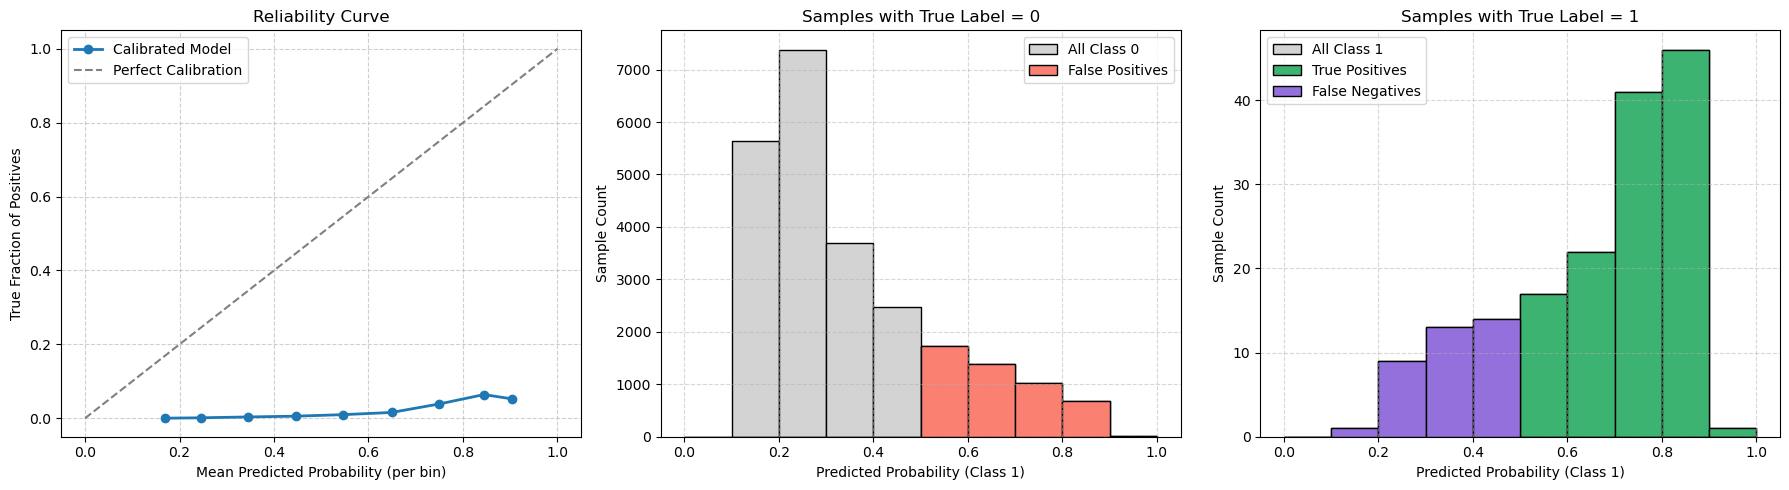

In [14]:
# Voting Classifier with Categories
plot_calibration_and_error_distributions_before_true_cal(
    y_true=y_val,
    models=[model_5, model_7, model_8],
    X=X_val_proc,
    threshold=0.5
)

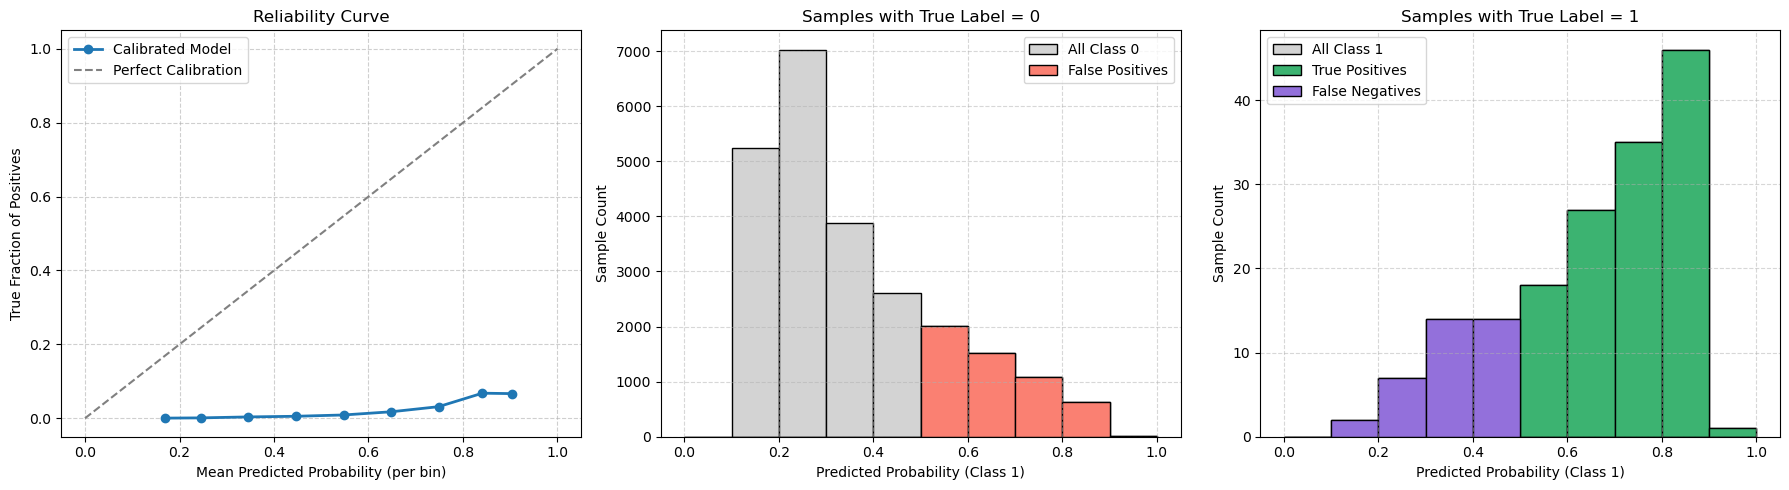

In [17]:
# Voting Classifier Without Categories
plot_calibration_and_error_distributions_before_true_cal(
    y_true=y_val,
    models=[model_2_wo_cat, model_7_wo_cat, model_8_wo_cat],
    X=X_val_wo_cat_proc,
    threshold=0.5
)

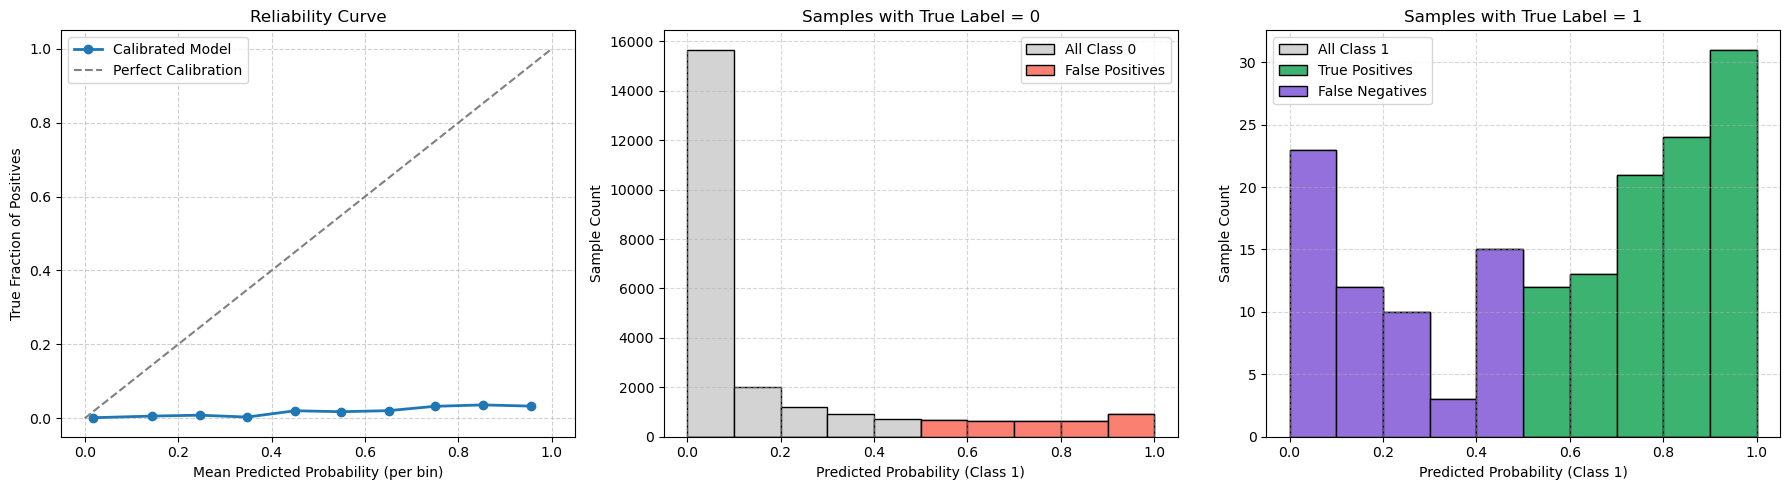

In [18]:
# balanced model
plot_calibration_and_error_distributions_before_true_cal(
    y_true=y_val,
    models=model_4,
    X=X_val_proc,
    threshold=0.5
)

Calibrate the Models


In [19]:
# wrap already-fitted model
cal_model_2_wo_cat = CalibratedClassifierCV(estimator=model_2_wo_cat, method='sigmoid', cv='prefit')
cal_model_7_wo_cat = CalibratedClassifierCV(estimator=model_7_wo_cat, method='sigmoid', cv='prefit')
cal_model_8_wo_cat = CalibratedClassifierCV(estimator=model_8_wo_cat, method='sigmoid', cv='prefit')

cal_model_4 = CalibratedClassifierCV(estimator=model_4, method='sigmoid', cv='prefit')
cal_model_5 = CalibratedClassifierCV(estimator=model_5, method='sigmoid', cv='prefit')
cal_model_6 = CalibratedClassifierCV(estimator=model_6, method='sigmoid', cv='prefit')
cal_model_7 = CalibratedClassifierCV(estimator=model_7, method='sigmoid', cv='prefit')
cal_model_8 = CalibratedClassifierCV(estimator=model_8, method='sigmoid', cv='prefit' )
cal_model_9 = CalibratedClassifierCV(estimator=model_9, method='sigmoid', cv='prefit' )
cal_model_10 = CalibratedClassifierCV(estimator=model_10, method='sigmoid', cv='prefit' )


# fit calibration model on calibration set
cal_model_4.fit(X_cal_proc, y_cal)
cal_model_5.fit(X_cal_proc, y_cal)
cal_model_6.fit(X_cal_proc, y_cal)
cal_model_7.fit(X_cal_proc, y_cal)
cal_model_8.fit(X_cal_proc, y_cal)
cal_model_9.fit(X_cal_proc, y_cal)
cal_model_10.fit(X_cal_proc, y_cal)
cal_model_2_wo_cat.fit(X_cal_wo_cat_proc, y_cal)
cal_model_7_wo_cat.fit(X_cal_wo_cat_proc, y_cal)
cal_model_8_wo_cat.fit(X_cal_wo_cat_proc, y_cal)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.6,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.01, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=-3,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

Manual 'Voting' Classifier


**With** Categories


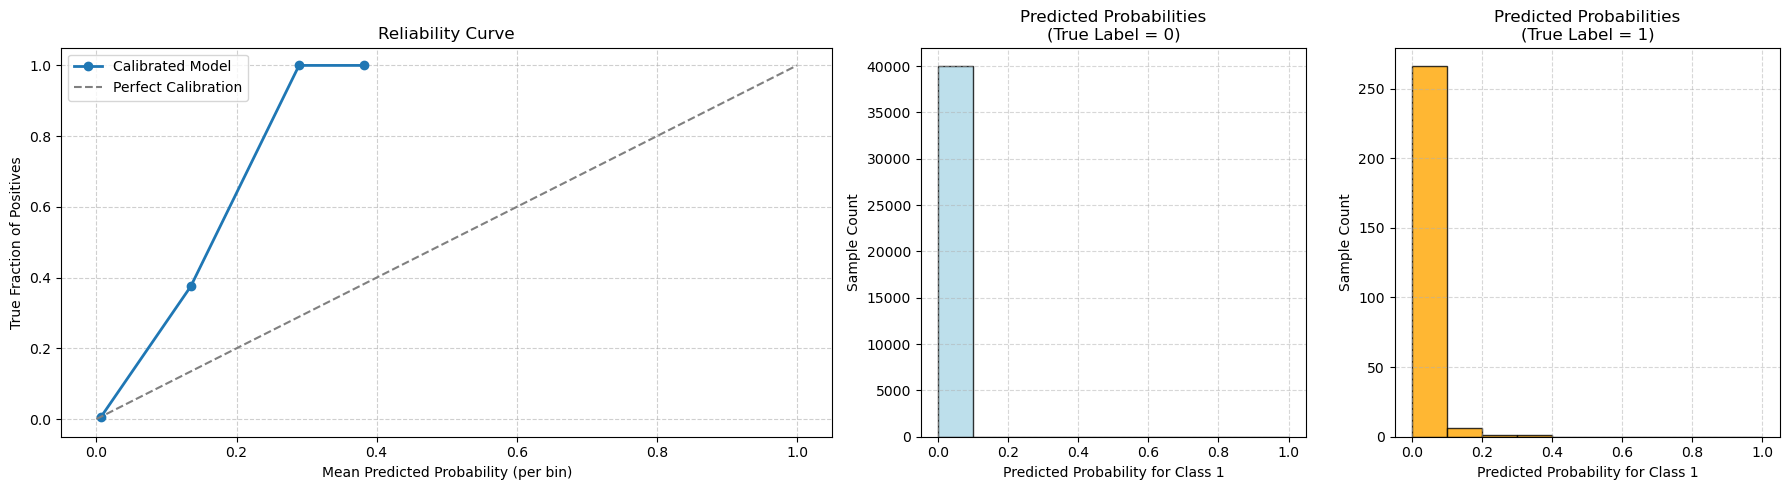


Classification Report @ Threshold = 0.00685
              precision    recall  f1-score   support

           0       1.00      0.73      0.84     40000
           1       0.02      0.81      0.04       274

    accuracy                           0.73     40274
   macro avg       0.51      0.77      0.44     40274
weighted avg       0.99      0.73      0.84     40274

Calibration Error (ECE, 10 bins): 0.00026


In [20]:
# voting classifier with categories
plot_calibration_and_class_distributions(
    [cal_model_5, cal_model_7, cal_model_8],
    X_test_proc,
    y_test
)

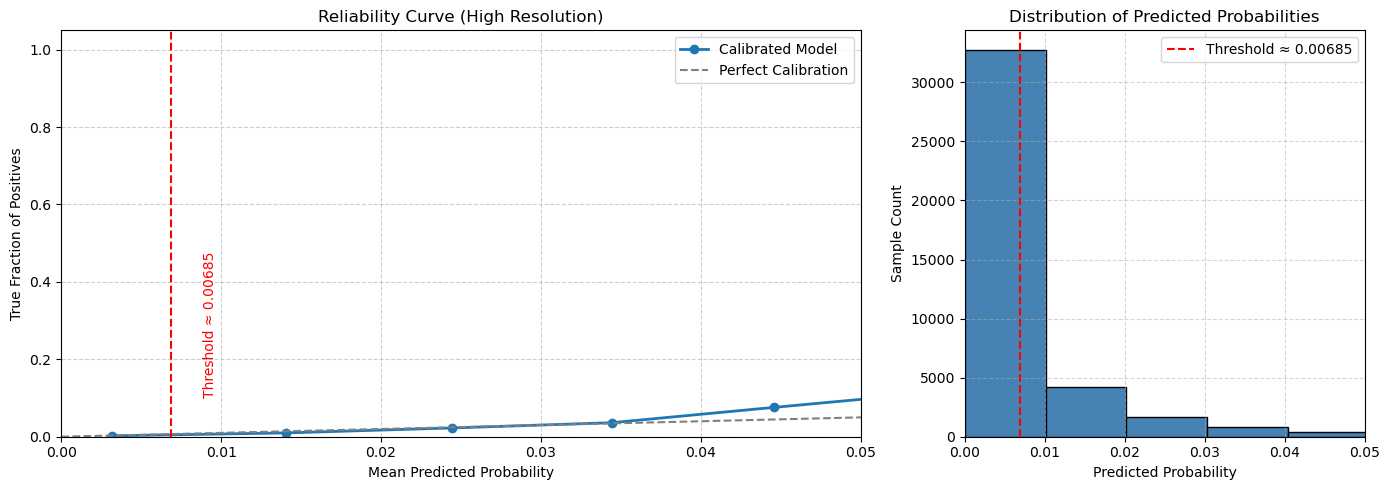

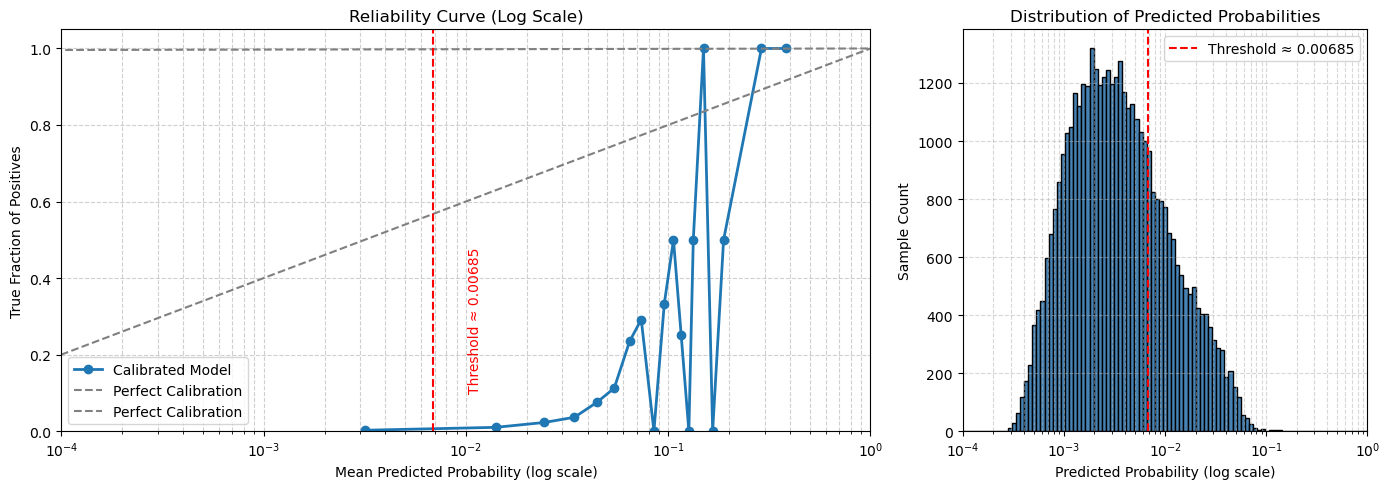

In [21]:
# Linear scale plot (zoom near 0)
plot_high_res_reliability_and_hist(models=[cal_model_5, cal_model_7, cal_model_8],
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=False)

# Log scale plot
plot_high_res_reliability_and_hist(models=[cal_model_5, cal_model_7, cal_model_8],
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=True)

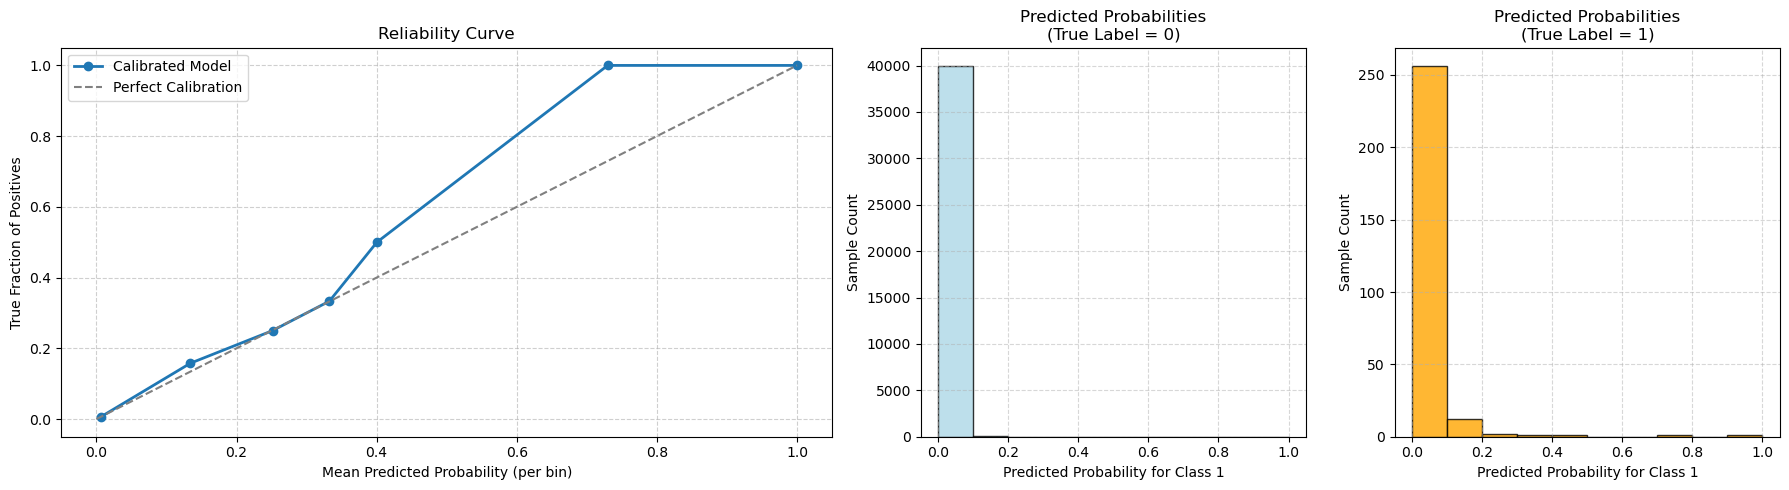


Classification Report @ Threshold = 0.00685
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     40000
           1       0.02      0.80      0.04       274

    accuracy                           0.72     40274
   macro avg       0.51      0.76      0.44     40274
weighted avg       0.99      0.72      0.83     40274

Calibration Error (ECE, 10 bins): 0.00012


In [22]:
# balanced model with categories
plot_calibration_and_class_distributions(
    cal_model_4,
    X_test_proc,
    y_test
)

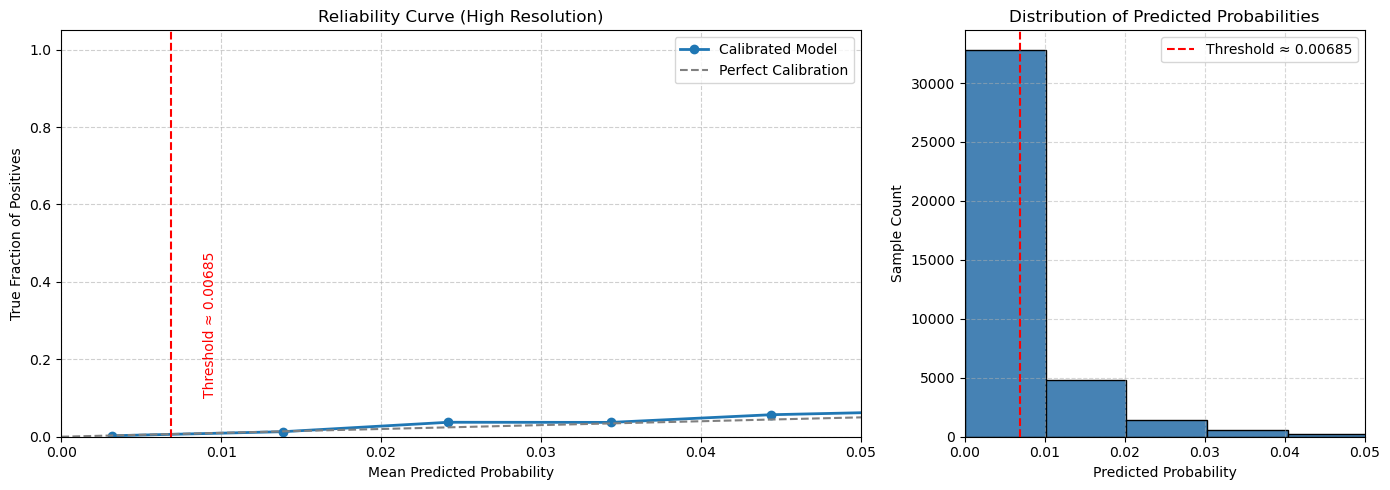

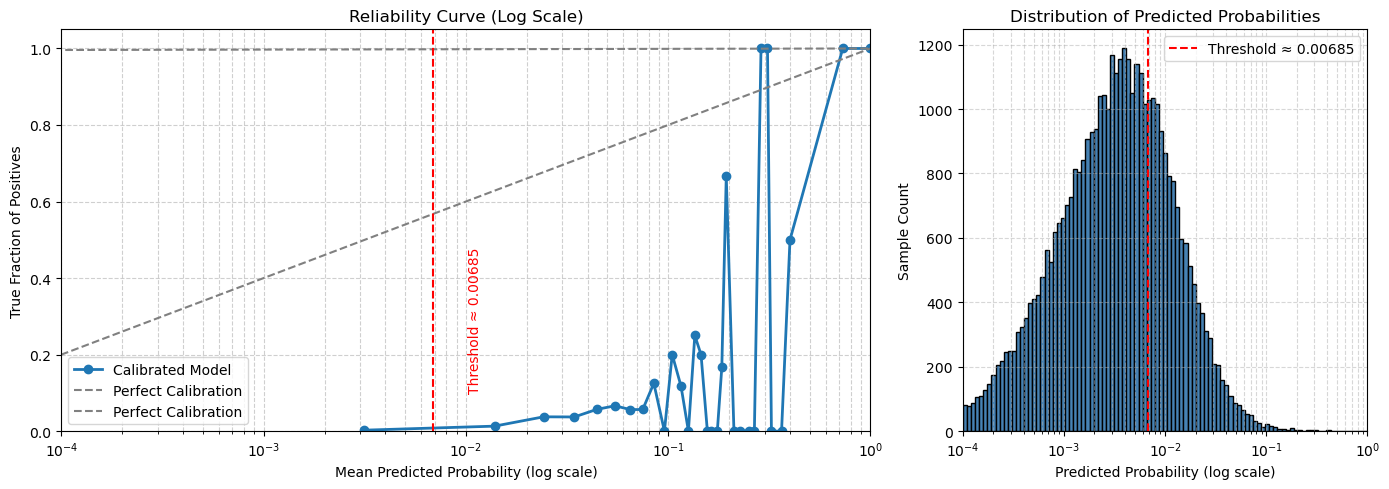

In [23]:
# Linear scale plot (zoom near 0)
plot_high_res_reliability_and_hist(models=cal_model_4,
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=False)

# Log scale plot
plot_high_res_reliability_and_hist(models=cal_model_4,
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=True)

**Without** Categories


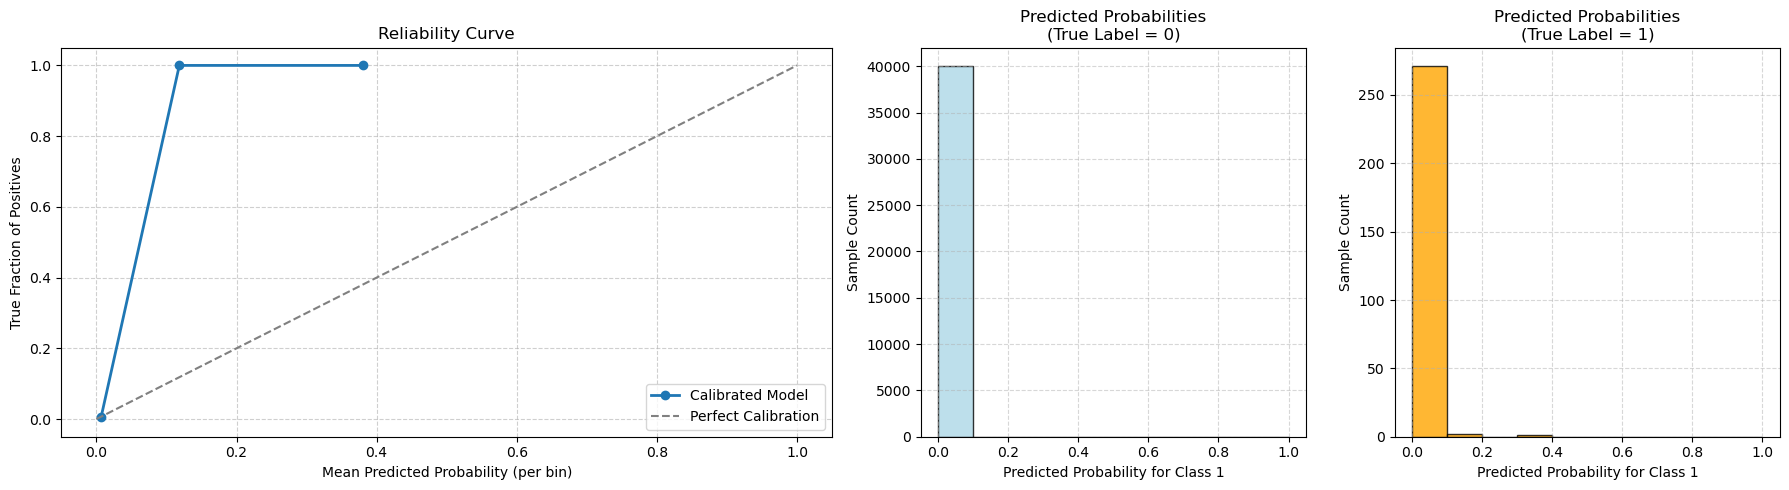


Classification Report @ Threshold = 0.00685
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     40000
           1       0.02      0.79      0.04       274

    accuracy                           0.72     40274
   macro avg       0.51      0.76      0.44     40274
weighted avg       0.99      0.72      0.83     40274

Calibration Error (ECE, 10 bins): 0.00014


In [24]:
# voting classifier without categories
plot_calibration_and_class_distributions(
    [cal_model_2_wo_cat, cal_model_7_wo_cat, cal_model_8_wo_cat],
    X_test_wo_cat_proc,
    y_test
)

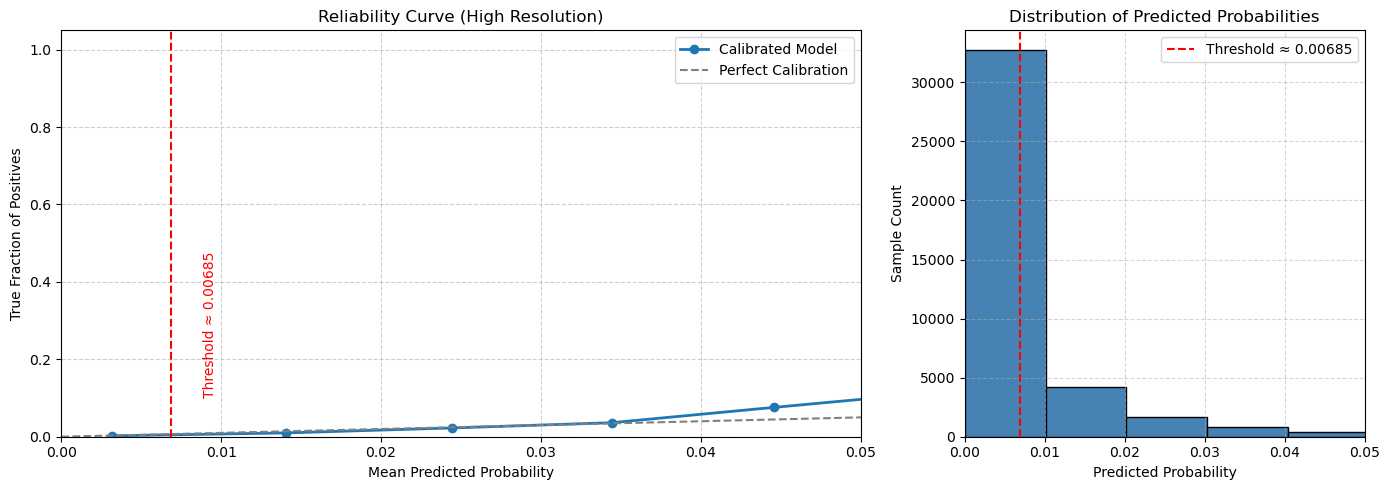

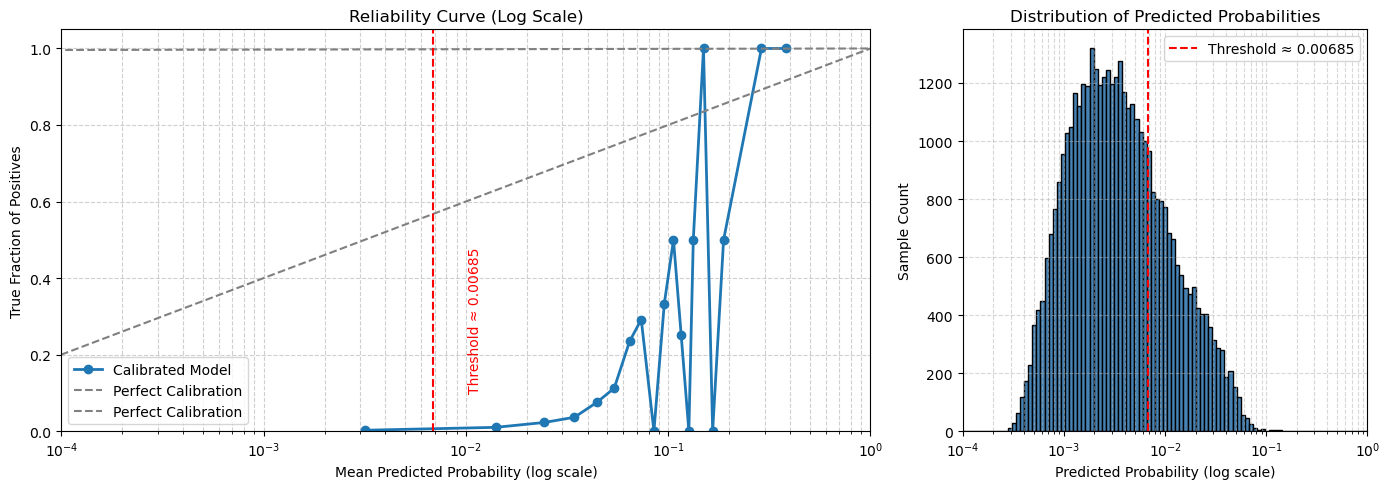

In [25]:
# Linear scale plot (zoom near 0)
plot_high_res_reliability_and_hist(models=[cal_model_5, cal_model_7, cal_model_8],
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=False)

# Log scale plot
plot_high_res_reliability_and_hist(models=[cal_model_5, cal_model_7, cal_model_8],
                                   X=X_test_proc,
                                   y_true=y_test,
                                   log_scale=True)

Anamoly Detection With Voting Classifier With Categories


In [26]:
models = [cal_model_5, cal_model_7, cal_model_8]
proba_list = [model.predict_proba(X_test_proc) for model in models]
avg_proba = sum(proba_list) / len(proba_list)
proba_class1 = avg_proba[:, 1]

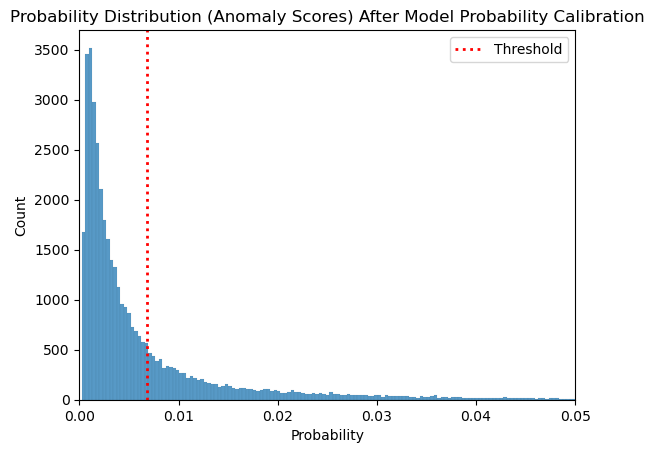

In [ ]:
# probability distribution of all products
sns.histplot(avg_proba[:, 1])
#plt.xscale('log')
plt.xlim(0, 0.05) 
plt.xlabel('Probability')
plt.title('Probability Distribution (Anomaly Scores) After Model Probability Calibration')

# Add vertical dotted line at x = 1/146
plt.axvline(x=1/146, color='red', linestyle=':', linewidth=2, label = 'Threshold')
plt.legend()
plt.show()


Anomaly threshold (90th percentile among true class 0): 0.0170
Number of flagged anomalies: 4000


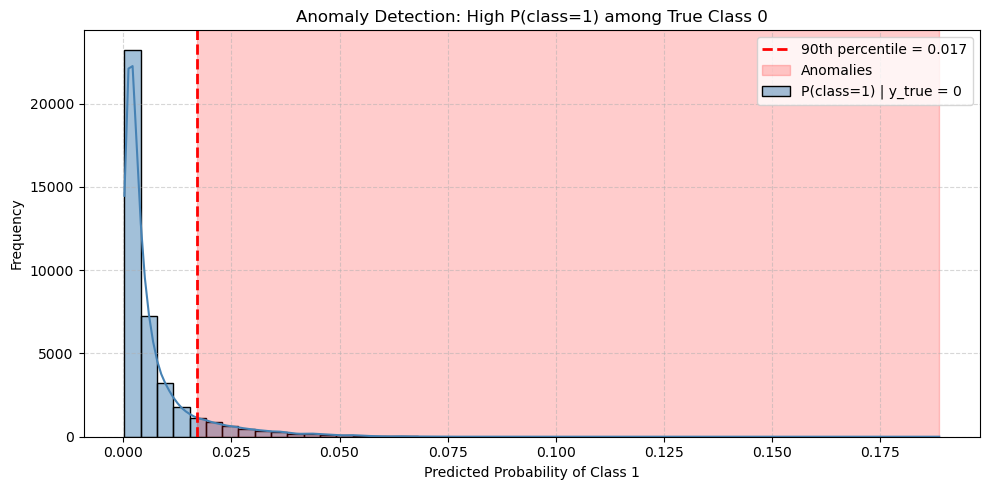

In [28]:
df = pd.DataFrame({
    'y_true': y_test,
    'proba_class1': proba_class1
})

# Filter to only true class = 0
df_negatives = df[df['y_true'] == 0]

# set anomaly threshold
threshold = df_negatives['proba_class1'].quantile(0.90)

# flag anomalies
anomalies = df_negatives[df_negatives['proba_class1'] > threshold]

print(f"Anomaly threshold (90th percentile among true class 0): {threshold:.4f}")
print(f"Number of flagged anomalies: {len(anomalies)}")

# plot 
plt.figure(figsize=(10, 5))
sns.histplot(df_negatives['proba_class1'], bins=50, kde=True, color='steelblue', edgecolor='black', label='P(class=1) | y_true = 0')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'90th percentile = {threshold:.3f}')
plt.axvspan(threshold, df_negatives['proba_class1'].max(), color='red', alpha=0.2, label='Anomalies')

plt.title('Anomaly Detection: High P(class=1) among True Class 0')
plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
